# Wzbogacanie danych

Wraz ze wzrostem liczby parametrów sieci problemem na powrót stał się brak danych. Występował on wcześniej, min. przy sieciach gęstych, gdzie, aby nauczyć takie rozwiązanie potrzeba było podczas treningu podać niemalże wszystkie możliwe kombinacje danych. Wtedy rozwiązaniem okazało się wprowadzenie sieci splotowych, w których perceptrony zgromadzono w przesuwające się po danych wejściowych oknach, dzięki temu stało się możliwe wykorzystywanie tych samych wyuczonych elementów w stosunku do dowolnego fragmentu obrazu.



Nowe podejście do wspomnianego problemu jest realizowane dwutorowo. Po pierwsze generuje się dodatkowe obrazy, na podstawie tych już istniejących w zbiorze, dzięki czemu algorytm ma więcej informacji o tym, które cech sa istotne, a które nie. Te elementy, które w dodanych obrazach pozostają niezmienne, klasyfikator traktuje jako istotne, natomiast te, które się zmieniają, ignoruje. Drugim sposobem jest kopiowanie wyuczonych fragmentów sieci, co jest możliwe, dzięki temu, że część zdolności, które musi nabyć klasyfikator, jest w dużej mierze niezależna od konkretnego problemu. Z drugiej strony te zdolności często wymagają sporej ilości obliczeń i danych przy treningu, co daje dodatkowe korzyści, a w niektórych przypadkach, w szczególności, gdy występuje problem braku wystarczającej liczby różnorodnych przykładów, w ogóle umożliwia skuteczny trening.



Jeden z tego typu problemów jest przedmiotem niniejszego ćwiczenia. Zbiór Fashion-MNIST zawiera dużą liczbę, w zbliżony sposób wykonanych fotografii. Jest to stosunkowo łatwy zbiór do osiągnięcia na nim wysokiej skuteczności, nawet dla małych sieci typu LeNet-5, ale z powodu na niską różnorodność, wytrenowane na nim modele słabo adaptują się do obrazów naturalnych. Aby zaradzić temu problemowi, w niniejszym ćwiczeniu wykorzystano wagi wyliczone na podstawie zbioru ImageNet. W związku z tym głównym wyzwaniem pozostaje takie dostosowanie klasyfikatora do nowego problemu, aby nie utracić wcześniej nabytych zdolności.

## Zależności

In [1]:
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tf_keras as keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import os
import datetime

%load_ext tensorboard

print(tf.__version__)
print(keras.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-11-27 21:54:16.851232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 21:54:16.851395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 21:54:16.988013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
2.15.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Klasyfikator obrazów ze zbioru ImageNet

### Pobranie klasyfikatora

In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

inception_v1 = "https://www.kaggle.com/models/google/inception-v1/TensorFlow2/classification/2"
inception_v2 = "https://www.kaggle.com/models/google/inception-v2/TensorFlow2/classification/2"
inception_resnet_v2 = "https://www.kaggle.com/models/google/inception-resnet-v2/TensorFlow2/classification/2" #299

resnet50_v1 = "https://www.kaggle.com/models/google/resnet-v1/TensorFlow2/50-classification/2"
resnet101_v1 = "https://www.kaggle.com/models/google/resnet-v1/TensorFlow2/101-classification/2"
resnet152_v1 = "https://www.kaggle.com/models/google/resnet-v1/TensorFlow2/152-classification/2"

resnet50_v2 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/50-classification/2"
resnet101_v2 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-classification/2"
resnet152_v2 = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/152-classification/2"

efficientnet_b0_v1 = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-classification/1"
efficientnet_b4_v1 = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b4-classification/1"
efficientnet_b7_v1 = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b7-classification/1"

efficientnet_b0_v2 = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-classification/2"
nasnet_mobile = "https://www.kaggle.com/models/google/nasnet/TensorFlow2/mobile-classification/2"

classifier_model = resnet152_v2
IMAGE_SIZE = 224 #299
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
num_classes = 1000

classifier = keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

classifier.summary()

Attaching model 'google/resnet-v2/tensorflow2/152-classification/2' to your Kaggle notebook...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              60382697  
                                                                 
Total params: 60382697 (230.34 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 60382697 (230.34 MB)
_________________________________________________________________


### Uruchomienie klasyfikatora na pojedyńczym obrazie

1045585/1045585 [==============================] - 1s 1us/step


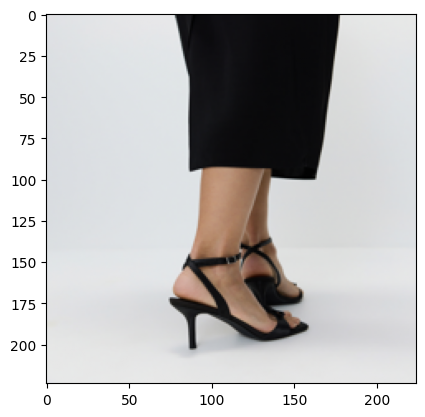

(224, 224, 3)

In [3]:
sandal1_model = 'https://static.reserved.com/media/catalog/product/4/6/463BU-99X-002-1-832324_2.jpg'

sandal1_pink = 'https://static.reserved.com/media/catalog/product/4/6/463BU-30X-011-2-836580_3.jpg'

sandal1 = 'https://static.reserved.com/media/catalog/product/4/6/463BU-99X-011-1-836560_2.jpg'

sandal2_model = 'https://static.reserved.com/media/catalog/product/6/0/6019Y-99X-001-1-814032_3.jpg'

sandal2 = 'https://static.reserved.com/media/catalog/product/6/0/6019Y-99X-011-1-808150_9.jpg'

sandal3_model = 'https://static.reserved.com/media/catalog/product/5/8/5828Y-SLV-001-1-801527_2.jpg'

sandal3 = 'https://static.reserved.com/media/catalog/product/5/8/5828Y-SLV-011-1-795997_3.jpg'

sandal4 = 'https://static.reserved.com/media/catalog/product/5/6/5698Y-99X-010-1-808148_1.jpg'



path = sandal1_model

path = keras.utils.get_file('image.jpg', path)

img = np.array( Image.open(path).resize((IMAGE_SIZE, IMAGE_SIZE)) ) / 255.0

os.remove(path)



plt.figure()

plt.imshow(img)

plt.grid(False)

plt.show()

img.shape


In [4]:
result = classifier.predict(img[np.newaxis, ...])

result.shape

1/1 [==============================] - 8s 8s/step


(1, 1001)

In [5]:
predicted_class = tf.math.argmax(result[0], axis=-1)

predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=775>

### Dekodowanie predykcji

In [6]:
labels_path = keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


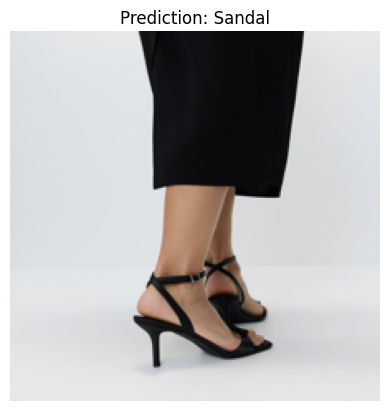

In [7]:
plt.imshow(img)
plt.axis('off')

predicted_class_name = imagenet_labels[predicted_class+1-result.shape[1]%num_classes]

_ = plt.title("Prediction: " + predicted_class_name.title())

## Import i wstępne przygotowanie danych

In [8]:
class ImgAug(keras.layers.Layer):      

  def call(self, img):

    offset=int((IMAGE_SIZE-img.shape[0])/2)
    return tf.image.grayscale_to_rgb(
        tf.image.pad_to_bounding_box(img, offset, offset, IMAGE_SIZE, IMAGE_SIZE)
    )



resize_and_rescale = keras.Sequential([
 #keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
 keras.layers.Rescaling(1./255),
 ImgAug()
])

In [9]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'fashion_mnist',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):

  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)
      
  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True)
test_ds = prepare(test_ds)
val_ds = prepare(val_ds)

num_classes = metadata.features['label'].num_classes
print(num_classes)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFKUPAZ/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteFKUPAZ/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
10


(32, 224, 224, 3)
(32,)


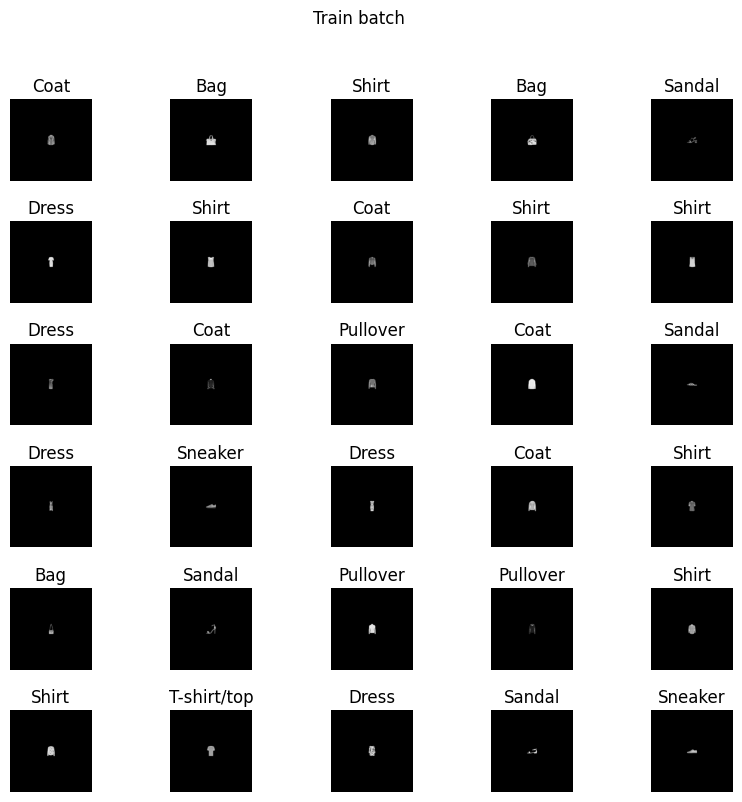

In [24]:
get_label_name = metadata.features['label'].int2str

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(get_label_name(labels_batch[n]))
  plt.axis('off')
_ = plt.suptitle("Train batch")

In [25]:
result = classifier.predict(image_batch)
print(result.shape)

1/1 [==============================] - 0s 47ms/step
(32, 1001)


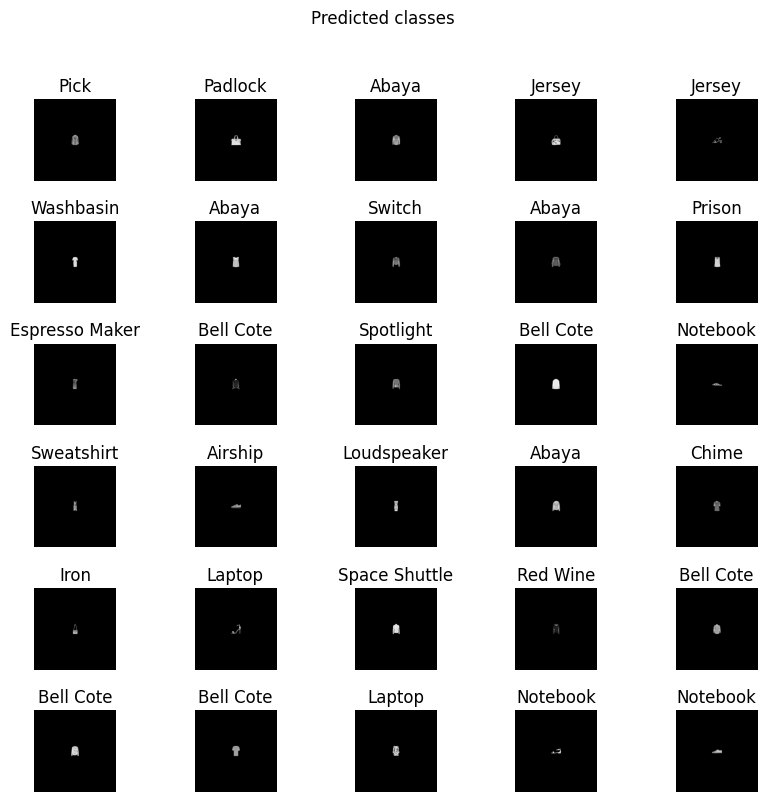

In [34]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  predicted_class = tf.math.argmax(result[n], axis=-1)
  predicted_class_name = imagenet_labels[predicted_class+1-result.shape[1]%num_classes]
  plt.title(predicted_class_name.title())
  plt.axis('off')
_ = plt.suptitle("Predicted classes")


## Trening modelu

In [36]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [37]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [38]:

model = keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [40]:
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [42]:
NUM_EPOCHS = 3

history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)


Epoch 1/3
1500/1500 [==============================] - 52s 34ms/step - loss: 0.3969 - acc: 0.8550 - val_loss: 0.4186 - val_acc: 0.8437
Epoch 2/3
1500/1500 [==============================] - 51s 34ms/step - loss: 0.3873 - acc: 0.8574 - val_loss: 0.4125 - val_acc: 0.8457
Epoch 3/3
1500/1500 [==============================] - 52s 34ms/step - loss: 0.3732 - acc: 0.8643 - val_loss: 0.3788 - val_acc: 0.8602


## Dekodowanie predykcji wytrenowanego modelu

In [46]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  predicted_class_name = get_label_name(predicted_label)
  true_class_name = get_label_name(true_label)
  plt.xlabel("{} {:2.0f}% ({})".format(predicted_class_name.title(),
                                100*np.max(predictions_array),
                                true_class_name.title()),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [52]:
probability_model = keras.Sequential([model, 
                                         keras.layers.Softmax()])

In [58]:
result = probability_model.predict(img[np.newaxis, ...])

result.shape

1/1 [==============================] - 1s 1s/step


(1, 10)

In [55]:
for label in range(10):
    print(label, " ",get_label_name(label))

0   T-shirt/top
1   Trouser
2   Pullover
3   Dress
4   Coat
5   Sandal
6   Shirt
7   Sneaker
8   Bag
9   Ankle boot


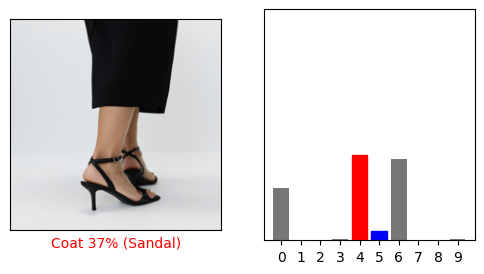

In [60]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, result[i], [5], img[np.newaxis, ...])
plt.subplot(1,2,2)
plot_value_array(i, result[i],  [5])
plt.show()

1/1 [==============================] - 1s 629ms/step


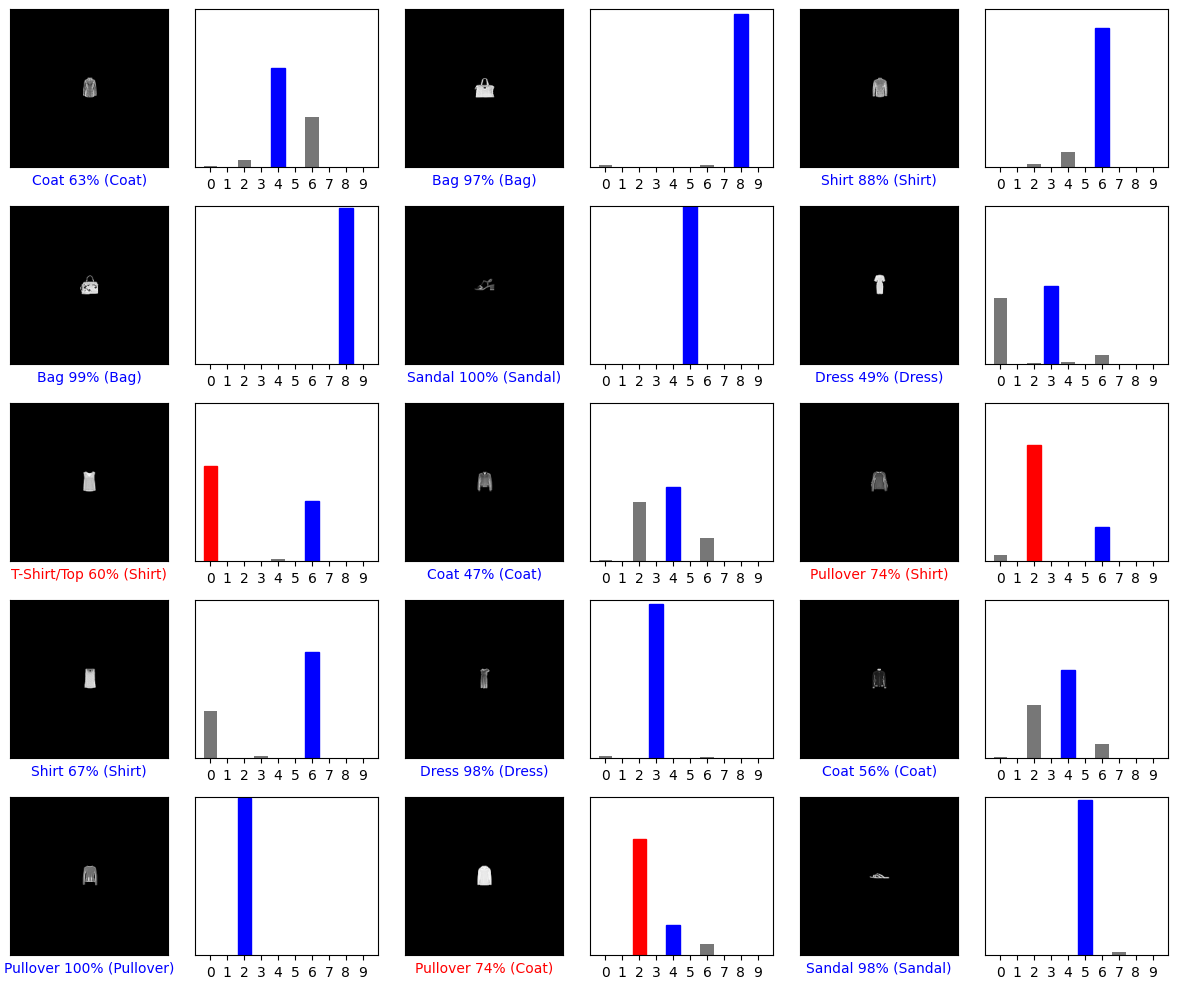

In [53]:
result = probability_model.predict(image_batch)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, result[i], labels_batch, image_batch)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, result[i], labels_batch)
plt.tight_layout()
plt.show()

## Zadania

1. Pobierz z Internetu co najmniej kilkanaście fotografii (do 30) należących do klas ze zbioru Fasion-MNIST, zbuduj z nich niewielki zbiór i sprawdź na nim rezultaty kilku klasyfikatorów wytrenowanych na zbiorze ImageNet. Wybierz najlepszy z nich i użyj go do treningu. (1 pkt)
2. Dodaj modyfikacje danych treningowych polegające na losowych zmianach rozmiaru i położenia. (1 pkt)
3. W zbiorze Fashion-MNIST wszystkie obrazy są monochromatyczne. Wzbogać przykłady treningowe o kolory. (1 pkt)
4. Zweryfikuj wyniki na wcześniej przygotowanym, własnym zbiorze obrazów a następnie wprowdź kolejne przekształcenia obrazów treningowych, tak aby zwiększyć celność predykcji. (2 pkt)



## Źródła

- [Transfer learning with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
- [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
